# Tutorial 5: Uplift modeling

In [1]:
%load_ext autoreload
%autoreload 2

## Install LightAutoML

Uncomment if doesn't clone repository by git. (ex.: colab, kaggle version)

In [2]:
#! pip install -U lightautoml

## Import necessary libraries

In [3]:
# Standard python libraries
from copy import deepcopy
import os
import requests

# Installed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

from lightautoml.addons.uplift.base import AutoUplift, BaseLearnerWrapper, MetaLearnerWrapper
from lightautoml.addons.uplift import metalearners
from lightautoml.addons.uplift.metrics import (_available_uplift_modes,
                                               TUpliftMetric,
                                               calculate_graphic_uplift_curve,
                                               calculate_min_max_uplift_auc,
                                               calculate_uplift_at_top,
                                               calculate_uplift_auc,
                                               perfect_uplift_curve)
from lightautoml.addons.uplift.utils import create_linear_automl
from lightautoml.report.report_deco import ReportDecoUplift


%matplotlib inline

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Parameters

### Setting

In [4]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name
TREATMENT_NAME = 'CODE_GENDER'

### Fix torch number of threads and numpy seed

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## Example data load

Load a dataset from the repository if doesn't clone repository by git.

In [6]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sberbank-ai-lab/LightAutoML/master/example_data/test_data_files/sampled_app_train.csv'

In [7]:
%%time

if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

CPU times: user 133 µs, sys: 0 ns, total: 133 µs
Wall time: 120 µs


In [8]:
%%time

data = pd.read_csv(DATASET_FULLNAME)
data.head()

CPU times: user 85.5 ms, sys: 20.7 ms, total: 106 ms
Wall time: 106 ms


## (Optional) Some user feature preparation

In [9]:
%%time 

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)
data['report_dt'] = np.datetime64('2018-01-01')
data['constant'] = 1
data['allnan'] = np.nan
data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)
data['CODE_GENDER'] = (data['CODE_GENDER'] == 'M').astype(int)

CPU times: user 93 ms, sys: 2.98 ms, total: 96 ms
Wall time: 94.8 ms


## Data splitting for train-test

In [10]:
%%time


stratify_value = data[TARGET_NAME] + 10 * data[TREATMENT_NAME]
train, test = train_test_split(data, test_size=3000, stratify=stratify_value, random_state=42)
test_target, test_treatment = test[TARGET_NAME].values.ravel(), test[TREATMENT_NAME].values.ravel()

CPU times: user 8.27 ms, sys: 4.11 ms, total: 12.4 ms
Wall time: 11.2 ms


## Setup columns roles

In [11]:
%%time

roles = {
    'target': TARGET_NAME,
    'treatment': TREATMENT_NAME,
    DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt'
}

CPU times: user 23 µs, sys: 10 µs, total: 33 µs
Wall time: 40.8 µs


## AutoUplift (use predefined uplift methods)

### Fit autouplift

In [12]:
%%time

task = Task('binary')

autouplift = AutoUplift(task,
                        metric='adj_qini', 
                        has_report=True,
                        test_size=0.2, 
                        timeout=200,
                        # timeout_metalearner=5
)

autouplift.fit(train, roles, verbose=1)

[15:25:36] Train data shape: (1912, 124)



/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[15:25:37] Layer 1 train process start. Time left 9999999998.91 secs
[15:25:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:25:39] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7125691699604744
[15:25:39] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:25:39] Time left 9999999996.36 secs

[15:25:39] Layer 1 training completed.

[15:25:39] Train data shape: (3688, 124)

[15:25:41] Layer 1 train process start. Time left 9999999998.68 secs
[15:25:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:25:44] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7316746701373305
[15:25:44] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:25:44] Time left 9999999995.56 secs

[15:25:44] Layer 1 training completed.

[15:25:44] Uplift candidate #0 [__TLearner__Default__] is fitted
[15:25:44] Train data shape: (5600, 124)

[15:25:45] Layer 1 train process start. Time left 9999999998.58 secs
[15:25:46] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[15:26:09] Layer 1 train process start. Time left 16.20 secs
[15:26:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:26:10] Time limit exceeded after calculating fold 2

[15:26:10] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7126587148903424
[15:26:10] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:26:10] Time left 14.42 secs

[15:26:11] Selector_LightGBM fitting and predicting completed
[15:26:12] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:26:13] Time limit exceeded after calculating fold 1

[15:26:13] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7259725400457666
[15:26:13] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:26:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[15:26:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:26:14] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:26:16] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost

### Show rating of uplift methods (meta-learners)

In [13]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 0 ns, sys: 2.08 ms, total: 2.08 ms
Wall time: 1.91 ms


###  Get best metalearner

In [14]:
%%time 

best_metalearner = autouplift.create_best_metalearner(
    update_metalearner_params={'timeout': None},
    update_baselearner_params={'timeout': 30}
)
best_metalearner.fit(train, roles)
_ = best_metalearner.predict(test);

CPU times: user 59 s, sys: 73.9 ms, total: 59.1 s
Wall time: 23.2 s


### Predict to test data and check metrics

In [15]:
%%time

uplift_pred, treatment_pred, control_pred = best_metalearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68530
	Control   = 0.73299
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02621 (0.15812)
	Perfect       = 0.09438
CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.17 s


## AutoUplift (custom uplift methods)

### Fit autouplift

In [16]:
%%time

# Set uplift candidate for choosing best of them
# !!!ATTENTION!!!
#    This is a demonstration of the possibilities, 
#    You may use default set of candidates 

task = Task('binary')

uplift_candidates = [
    MetaLearnerWrapper(
        name='TLearner__Default', 
        klass=metalearners.TLearner, 
        params={'base_task': task}
    ),  
    MetaLearnerWrapper(
        name='TLearner__Custom', 
        klass=metalearners.TLearner, 
        params={
            'treatment_learner': BaseLearnerWrapper(
                name='__TabularAutoML__',
                klass=TabularAutoML, 
                params={'task': task, 'timeout': 10}),
            'control_learner': BaseLearnerWrapper(
                name='__Linear__',
                klass=create_linear_automl,
                params={'task': Task('binary')})
        }
    ),
    MetaLearnerWrapper(
        name='XLearner__Custom',
        klass=metalearners.XLearner,
        params={
            'outcome_learners': [
                TabularAutoML(task=task, timeout=10), # [sec] , Only speed up example, don't change it!
                create_linear_automl(task=Task('binary'))
            ],
            'effect_learners': [BaseLearnerWrapper(
                name='__TabularAutoML__',
                klass=TabularAutoML, 
                params={'task': Task('reg'), 'timeout': 5})],
            'propensity_learner': create_linear_automl(task=Task('binary')),
        }    
    )
]

autouplift = AutoUplift(task,
                        uplift_candidates=uplift_candidates, 
                        metric='adj_qini', 
                        test_size=0.2, 
                        threshold_imbalance_treatment=0.0,    # Doesn't affect, see warnings
                        timeout=600)                          # Doesn't affect, see warnings

autouplift.fit(train, roles, verbose=1)

[15:29:04] Train data shape: (1912, 124)



/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[15:29:05] Layer 1 train process start. Time left 9999999999.04 secs
[15:29:05] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:29:07] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7125691699604744
[15:29:07] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:29:07] Time left 9999999996.80 secs

[15:29:07] Layer 1 training completed.

[15:29:07] Train data shape: (3688, 124)

[15:29:08] Layer 1 train process start. Time left 9999999998.79 secs
[15:29:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:29:11] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7316410106812673
[15:29:11] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:29:11] Time left 9999999995.80 secs

[15:29:11] Layer 1 training completed.

[15:29:11] Uplift candidate #0 [TLearner__Default] is fitted
[15:29:12] Stdout logging level is INFO.
[15:29:12] Task: binary

[15:29:12] Start automl preset with listed constraints:
[15:29:12] - time: 10.00 seconds
[15:29:12] - CPU

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[15:29:13] Layer 1 train process start. Time left 9.16 secs
[15:29:13] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:29:13] Time limit exceeded after calculating fold 1

[15:29:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7585430968726163
[15:29:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:29:13] Time left 8.35 secs

[15:29:14] Selector_LightGBM fitting and predicting completed
[15:29:15] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:29:15] Time limit exceeded after calculating fold 0

[15:29:15] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7342486651411136
[15:29:15] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:29:15] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[15:29:17] Time limit exceeded after calculating fold 3

[15:29:17] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6209033816425121
[15:29:17] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:29:17] Start hyperparameters opt

### Show rating of uplift methods (meta-learners)

In [17]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 1.8 ms, sys: 280 µs, total: 2.08 ms
Wall time: 1.87 ms


### Predict to test data and check metrics

In [18]:
%%time

uplift_pred, treatment_pred, control_pred = autouplift.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68803
	Control   = 0.74497
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02607 (0.15647)
	Perfect       = 0.09438
CPU times: user 2.47 s, sys: 42 ms, total: 2.51 s
Wall time: 1.3 s


## AutoUplift with custom metric

### Fit autouplift

In [19]:
%%time

# Using a custom metric
# How to determine custom metric, see below

task = Task('binary')


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)
    
        return 0.5 * (up_10 + up_20)

autouplift = AutoUplift(task,
                        add_dd_candidates=True,
                        metric=CustomUpliftMetric(), 
                        test_size=0.2, 
                        threshold_imbalance_treatment=0.0,
                        cpu_limit=10,
                        timeout=100)

autouplift.fit(train, roles)

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/sasha/workspace/sber_ai_lab/LightAutoML/lightautoml/addons/uplift/metalearners.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

CPU times: user 4min 36s, sys: 2.68 s, total: 4min 39s
Wall time: 1min 41s


### Show rating of uplift methods (meta-learners)

In [20]:
%%time

rating_table = autouplift.get_metalearners_ranting()
rating_table

CPU times: user 1.91 ms, sys: 234 µs, total: 2.15 ms
Wall time: 1.88 ms


## MetaLearner

### TLearner

#### Fit on train data

In [21]:
%%time

# Default setting
tlearner = metalearners.TLearner(base_task=Task('binary'), cpu_limit=5)
tlearner.fit(train, roles)

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 20.5 s, sys: 29.4 ms, total: 20.6 s
Wall time: 7.71 s


#### Predict to test data and check metrics

In [22]:
%%time

uplift_pred, treatment_pred, control_pred = tlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68530
	Control   = 0.73299
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.01676 (0.04140)
	Perfect       = 0.09438
CPU times: user 648 ms, sys: 10.8 ms, total: 659 ms
Wall time: 529 ms


### XLearner

#### Fit on train data

In [23]:
%%time

# Custom base algorithm
xlearner = metalearners.XLearner(
    propensity_learner=TabularAutoML(task=Task('binary'), timeout=10),
    outcome_learners=[
        TabularAutoML(task=Task('binary'), timeout=10),
        TabularAutoML(task=Task('binary'), timeout=10)
    ],
    effect_learners=[
        TabularAutoML(task=Task('reg'), timeout=10),
        TabularAutoML(task=Task('reg'), timeout=10)
    ]
)
xlearner.fit(train, roles)

CPU times: user 2min 50s, sys: 19.9 s, total: 3min 10s
Wall time: 49.7 s


#### Predict to test data and check metrics

In [24]:
%%time

uplift_pred, treatment_pred, control_pred = xlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

print('--- Check scores ---')
print('OOF scores "ROC_AUC":')
print('\tTreatment = {:.5f}'.format(roc_auc_treatment))
print('\tControl   = {:.5f}'.format(roc_auc_control))
print('Uplift score of test group (default="adj_qini"):')
print('\tBaseline      = {:.5f}'.format(auc_base))
print('\tAlgo (Normed) = {:.5f} ({:.5f})'.format(uplift_auc_algo, uplift_auc_algo_normed))
print('\tPerfect       = {:.5f}'.format(auc_perfect))

--- Check scores ---
OOF scores "ROC_AUC":
	Treatment = 0.68045
	Control   = 0.71389
Uplift score of test group (default="adj_qini"):
	Baseline      = 0.01340
	Algo (Normed) = 0.02685 (0.16604)
	Perfect       = 0.09438
CPU times: user 4.96 s, sys: 251 ms, total: 5.21 s
Wall time: 1.92 s


## Uplift metrics and graphics (using xlearner predictions)

In [25]:
%%time 

UPLIFT_METRIC = 'adj_qini'

print("All available uplift metrics: {}".format(_available_uplift_modes))

All available uplift metrics: ('qini', 'cum_gain', 'adj_qini')
CPU times: user 469 µs, sys: 56 µs, total: 525 µs
Wall time: 417 µs


### Algorithm uplift curve 

In [26]:
%%time

# Algorithm curve
xs_xlearner, ys_xlearner = calculate_graphic_uplift_curve(
    test_target, uplift_pred, test_treatment, mode=UPLIFT_METRIC
)

CPU times: user 1.19 ms, sys: 143 µs, total: 1.34 ms
Wall time: 887 µs


### Baseline, perfect curve

In [27]:
# Baseline curve
xs_base, ys_base = xs_xlearner, xs_xlearner * ys_xlearner[-1]

# Perfect curver
perfect_uplift = perfect_uplift_curve(test_target, test_treatment)
xs_perfect, ys_perfect = calculate_graphic_uplift_curve(
    test_target, perfect_uplift, test_treatment, mode=UPLIFT_METRIC)

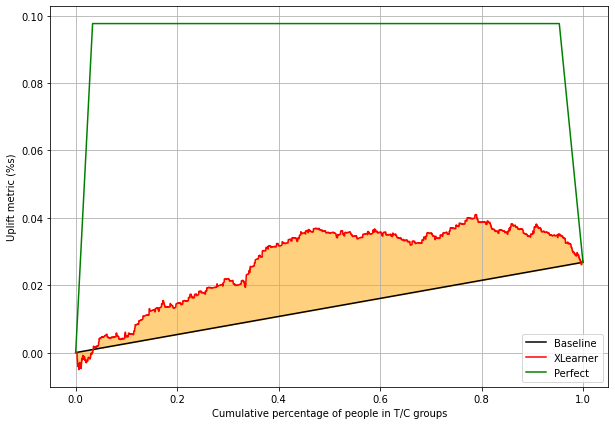

In [28]:
plt.figure(figsize=(10, 7))

plt.plot(xs_base, ys_base, 'black')
plt.plot(xs_xlearner, ys_xlearner, 'red')
plt.plot(xs_perfect, ys_perfect, 'green')

plt.fill_between(xs_xlearner, ys_base, ys_xlearner, alpha=0.5, color='orange')

plt.xlabel('Cumulative percentage of people in T/C groups')
plt.ylabel('Uplift metric (%s)'.format(UPLIFT_METRIC))
plt.grid()
plt.legend(['Baseline', 'XLearner', 'Perfect']);

### Uplift TOP-K

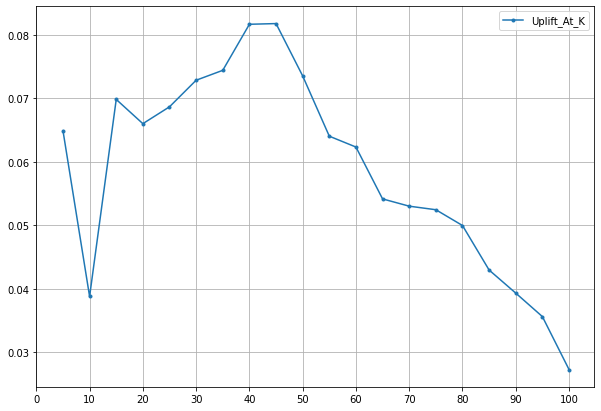

In [29]:
tops = np.arange(5, 101, 5)

uplift_at_tops = []
for top in tops:
    uat = calculate_uplift_at_top(test_target, uplift_pred, test_treatment, top=top)
    uplift_at_tops.append(uat)

plt.figure(figsize=(10, 7))

plt.plot(tops, uplift_at_tops, marker='.')

plt.legend(['Uplift_At_K'])
plt.xticks(np.arange(0, 101, 10))
plt.grid()

### Custom metric

In [30]:
# Custom metric can be used in AutoUplift
# There msut be a function's signature:
# def custom_metric(target, uplift_pred, treatment) -> float:


class CustomUpliftMetric(TUpliftMetric):
    def __call__(self, target: np.ndarray, uplift_pred: np.ndarray, treatment: np.ndarray) -> float:
        up_10 = calculate_uplift_at_top(target, uplift_pred, treatment, 10)
        up_20 = calculate_uplift_at_top(target, uplift_pred, treatment, 20)
    
        return 0.5 * (up_10 + up_20)


metric = CustomUpliftMetric()
metric_value = metric(test_target, uplift_pred, test_treatment)

print("Metric = {}".format(metric_value))

Metric = 0.05238574020765164


## Report

In [31]:
%%time

RDU = ReportDecoUplift()
tlearner_deco = RDU(metalearners.TLearner(base_task=Task('binary')))
tlearner_deco.fit(train, roles)
_ = tlearner_deco.predict(test)

# Path to report: PATH_TO_CURRENT_NOTEBOOK/lama_report/lama_interactive_report.html

/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/sasha/workspace/sber_ai_lab/LightAutoML/.venv/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 28.1 s, sys: 288 ms, total: 28.4 s
Wall time: 15.3 s
